# Part 2:Data Models

## Importing libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE

import xgboost
from xgboost import XGBClassifier

## Importing Data

In [98]:
#importing data
#df = pd.read_csv('Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv', low_memory=False)
df2020 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2020.csv', low_memory=False)
df2021 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2021.csv', low_memory=False)
df2022 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2022.csv', low_memory=False)
df2023 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2023.csv', low_memory=False)
df2024 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2024.csv', low_memory=False)
all_data = [df2020, df2021,df2022,df2023,df2024]

df = pd.concat(all_data)
df.head(5)

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_CODE,SOC_TITLE,FULL_TIME_POSITION,...,WILLFUL_VIOLATOR,SUPPORT_H1B,STATUTORY_BASIS,APPENDIX_A_ATTACHED,PUBLIC_DISCLOSURE,PREPARER_LAST_NAME,PREPARER_FIRST_NAME,PREPARER_MIDDLE_INITIAL,PREPARER_BUSINESS_NAME,PREPARER_EMAIL
0,I-200-19268-393467,Certified,2019-09-25,2019-10-01,NaN,H-1B,"APPLICATION ENGINEER, OMS [15-1199.02]",15-1199,"COMPUTER OCCUPATIONS, ALL OTHER",Y,...,N,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
1,I-200-19268-638983,Certified,2019-09-25,2019-10-01,NaN,H-1B,BI DEVELOPER II,15-1132,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
2,I-200-19268-177184,Certified,2019-09-25,2019-10-01,NaN,H-1B,QUALITY ENGINEER,17-2141,MECHANICAL ENGINEERS,Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
3,I-200-19268-936403,Certified,2019-09-25,2019-10-01,NaN,H-1B,"SOFTWARE DEVELOPER, APPLICATIONS",15-1132,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
4,I-200-19268-394079,Certified,2019-09-25,2019-10-01,NaN,H-1B,QUALITY ENGINEER LEVEL II,15-1199,"COMPUTER OCCUPATIONS, ALL OTHER",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,LEGAL@THEEGIANTS.COM


In [99]:
# Delete previous dataframes to free memory
del df2020, df2021, df2022, df2023, df2024, all_data

## Basic Data Processing 

### 1. Finding Annual Wage

In [104]:
#Salary Analysis
#Clean and convert salaries to numeric, handling outliers

unique_units = df['PW_UNIT_OF_PAY'].unique()
print(unique_units)

['Year' 'Hour' 'Bi-Weekly' nan 'Month' 'Week']


In [105]:
#"Prevailing Wage" * conversion factors to find annual wage
df['PREVAILING_WAGE'] = pd.to_numeric(df['PREVAILING_WAGE'], errors='coerce')
df = df[df['PREVAILING_WAGE'] > 0]  # Filter out non-positive values

conversion_factors = {
    'Year': 1,            # No Normalization
    'Month': 12,          # 12 months in a year
    'Bi-Weekly': 26,      # 26 bi-weekly periods in a year
    'Week': 52,           # 52 weeks in a year
    'Hour': 2080          # 52 weeks in a year x 40 hrs a week
}

df['ANNUAL_WAGE'] = df.apply(
    lambda row: row['PREVAILING_WAGE'] * conversion_factors.get(row['PW_UNIT_OF_PAY'], 1),
    axis=1
)

/var/folders/z0/qb5gklfx3495h7m28hm9r8lc0000gn/T/ipykernel_22805/3027307025.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANNUAL_WAGE'] = df.apply(


In [106]:
print(df[df['PW_UNIT_OF_PAY'] == 'Hour'][['PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'ANNUAL_WAGE']].head())

    PREVAILING_WAGE PW_UNIT_OF_PAY  ANNUAL_WAGE
1              39.0           Hour      81120.0
2              39.0           Hour      81120.0
3              53.0           Hour     110240.0
59             28.0           Hour      58240.0
60             29.0           Hour      60320.0


### 2. Finding Decision Duration of Applications

In [137]:
#get the processing time from subtracting decision date and start date and case status is certified
#processing the time into usable format
df.loc[:, 'BEGIN_DATE'] = pd.to_datetime(df['BEGIN_DATE'])
df.loc[:, 'DECISION_DATE'] = pd.to_datetime(df['DECISION_DATE'])
df.loc[:, 'RECEIVED_DATE'] = pd.to_datetime(df['RECEIVED_DATE'])

#ensure all days are calculated correctly
df.loc[:, "Decision_Duration"] = np.abs((df["DECISION_DATE"] - df["RECEIVED_DATE"]).dt.days)


## Filtering Out DataFrame

### 1. Selecting Features

In [112]:
#selecting features based on correlation coefficients from last section
selectdf = df.loc[:, 
    ['CASE_STATUS',
     'SOC_TITLE',
     'ANNUAL_WAGE',
     'SUPPORT_H1B',
     'H_1B_DEPENDENT',
     'EMPLOYER_NAME',
     'EMPLOYER_STATE',
     'EMPLOYER_CITY',
     'AGENT_REPRESENTING_EMPLOYER',
     'AGENT_ATTORNEY_STATE',
     'AGENT_ATTORNEY_CITY',
     'FULL_TIME_POSITION',
     'WORKSITE_STATE',
     'WORKSITE_CITY',
     'WORKSITE_POSTAL_CODE',
     'WORKSITE_WORKERS',
     'TOTAL_WORKER_POSITIONS',
     'RECEIVED_DATE',
     'Decision_Duration'
    ]]
selectdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562736 entries, 0 to 890367
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   CASE_STATUS                  object        
 1   SOC_TITLE                    object        
 2   ANNUAL_WAGE                  float64       
 3   SUPPORT_H1B                  object        
 4   H_1B_DEPENDENT               object        
 5   EMPLOYER_NAME                object        
 6   EMPLOYER_STATE               object        
 7   EMPLOYER_CITY                object        
 8   AGENT_REPRESENTING_EMPLOYER  object        
 9   AGENT_ATTORNEY_STATE         object        
 10  AGENT_ATTORNEY_CITY          object        
 11  FULL_TIME_POSITION           object        
 12  WORKSITE_STATE               object        
 13  WORKSITE_CITY                object        
 14  WORKSITE_POSTAL_CODE         object        
 15  WORKSITE_WORKERS             float64       
 16  TOTAL_

In [113]:
selectdf["WORKSITE_WORKERS"] = selectdf["WORKSITE_WORKERS"].fillna(0).astype(int)
selectdf.WORKSITE_WORKERS.value_counts()

WORKSITE_WORKERS
1      3382051
10       39484
3        23344
5        21866
25       17134
        ...   
91           1
69           1
39           1
121          1
120          1
Name: count, Length: 83, dtype: int64

In [114]:
selectdf.head(5)

,CASE_STATUS,SOC_TITLE,ANNUAL_WAGE,SUPPORT_H1B,H_1B_DEPENDENT,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_CITY,AGENT_REPRESENTING_EMPLOYER,AGENT_ATTORNEY_STATE,AGENT_ATTORNEY_CITY,FULL_TIME_POSITION,WORKSITE_STATE,WORKSITE_CITY,WORKSITE_POSTAL_CODE,WORKSITE_WORKERS,TOTAL_WORKER_POSITIONS,RECEIVED_DATE,Decision_Duration
0,Certified,"COMPUTER OCCUPATIONS, ALL OTHER",95118.0,NaN,N,"JO-ANN STORES, INC.",OH,HUDSON,Y,IL,CHICAGO,Y,OH,Hudson,44224,0,1,2019-09-25,6
1,Certified,"SOFTWARE DEVELOPERS, APPLICATIONS",81120.0,Y,Y,DENKEN SOLUTIONS INC.,CA,IRVINE,Y,FL,JACKSONVILLE,Y,TN,BRENTWOOD,37027,0,1,2019-09-25,6
2,Certified,MECHANICAL ENGINEERS,81120.0,Y,Y,"EPITEC, INC.",MI,SOUTHFIELD,Y,MI,TROY,Y,MI,Dearborn,48126,0,1,2019-09-25,6
3,Certified,"SOFTWARE DEVELOPERS, APPLICATIONS",110240.0,Y,Y,"SYSTEMS TECHNOLOGY GROUP, INC.",MI,TROY,N,NaN,NaN,Y,MI,Taylor,48180,0,1,2019-09-25,6
4,Certified,"COMPUTER OCCUPATIONS, ALL OTHER",65333.0,Y,Y,E-GIANTS TECHNOLOGIES LLC,IA,CLIVE,N,NaN,NaN,Y,OH,BLUE ASH,45242,0,1,2019-09-25,6


### 2. Filtering "CASE_STATUS" for Certified and Withdrawn 

In [115]:
#see count before
print(selectdf.CASE_STATUS.value_counts())

#filter out case status into certifief and withdrawn only
#save into selectdf_filtered
selectdf_filtered = selectdf[selectdf['CASE_STATUS'].isin(['Certified', 'Denied'])]
print(selectdf_filtered.CASE_STATUS.value_counts())

CASE_STATUS
Certified                3292311
Certified - Withdrawn     184634
Withdrawn                  64014
Denied                     21777
Name: count, dtype: int64
CASE_STATUS
Certified    3292311
Denied         21777
Name: count, dtype: int64


In [116]:
#free up memory
del df, selectdf

### 3. Transforming DataFrame

In [139]:
'''
Preprocessing features
#:'Decision_Duration','TOTAL_WORKER_POSITIONS','ANNUAL_WAGE'
Categorical:
    'CASE_STATUS',
    'SOC_TITLE',
    'SUPPORT_H1B',
    'H_1B_DEPENDENT',
    'EMPLOYER_NAME',
    'EMPLOYER_STATE',
    'EMPLOYER_CITY',
    'AGENT_REPRESENTING_EMPLOYER',
    'AGENT_ATTORNEY_STATE',
    'AGENT_ATTORNEY_CITY',
    'FULL_TIME_POSITION',
    'WORKSITE_STATE',
    'WORKSITE_CITY',
    'WORKSITE_POSTAL_CODE',
    'RECEIVED_DATE']]
'''
selectdf_filtered = selectdf_filtered.copy()

#Label Encoding for categorical features
cat_columns = [
    'CASE_STATUS',
    'SOC_TITLE',
    'SUPPORT_H1B',
    'H_1B_DEPENDENT',
    'EMPLOYER_NAME',
    'EMPLOYER_STATE',
    'EMPLOYER_CITY',
    'AGENT_REPRESENTING_EMPLOYER',
    'AGENT_ATTORNEY_STATE',
    'AGENT_ATTORNEY_CITY',
    'FULL_TIME_POSITION',
    'WORKSITE_STATE',
    'WORKSITE_CITY',
    'WORKSITE_POSTAL_CODE',
    'RECEIVED_DATE'
    ]

#prevent categories from mismatching
label_encoder= {}
for col in cat_columns:
    label_encoder[col] = LabelEncoder()
    selectdf_filtered[col] = label_encoder[col].fit_transform(selectdf_filtered[col])

In [140]:
print(selectdf_filtered.CASE_STATUS.value_counts())
print(selectdf_filtered.info())

CASE_STATUS
0    3292311
1      21777
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3314088 entries, 0 to 890367
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   CASE_STATUS                  int64  
 1   SOC_TITLE                    int64  
 2   ANNUAL_WAGE                  float64
 3   SUPPORT_H1B                  int64  
 4   H_1B_DEPENDENT               int64  
 5   EMPLOYER_NAME                int64  
 6   EMPLOYER_STATE               int64  
 7   EMPLOYER_CITY                int64  
 8   AGENT_REPRESENTING_EMPLOYER  int64  
 9   AGENT_ATTORNEY_STATE         int64  
 10  AGENT_ATTORNEY_CITY          int64  
 11  FULL_TIME_POSITION           int64  
 12  WORKSITE_STATE               int64  
 13  WORKSITE_CITY                int64  
 14  WORKSITE_POSTAL_CODE         int64  
 15  WORKSITE_WORKERS             int64  
 16  TOTAL_WORKER_POSITIONS       int64  
 17  RECEIVED_DATE             

### 4. Defining target and features

In [141]:
# Define target and features
target = 'CASE_STATUS'
features = ['SOC_TITLE', 'ANNUAL_WAGE', 'SUPPORT_H1B', 'H_1B_DEPENDENT', 'EMPLOYER_NAME', 'EMPLOYER_STATE', 
            'EMPLOYER_CITY', 'AGENT_REPRESENTING_EMPLOYER', 'AGENT_ATTORNEY_STATE', 'AGENT_ATTORNEY_CITY',
            'FULL_TIME_POSITION', 'WORKSITE_STATE', 'WORKSITE_CITY', 'WORKSITE_POSTAL_CODE',
            'WORKSITE_WORKERS', 'TOTAL_WORKER_POSITIONS', 'RECEIVED_DATE', 'Decision_Duration']

X = selectdf_filtered[features]
y = selectdf_filtered[target]

#Ensuring y is integer
y = y.astype(int)

#Test,train,split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Models

### Logistic Regression

In [147]:
#Scaling features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [148]:
#Model with imbalance data
lg_imbalanced = LogisticRegression(max_iter=1000, solver='newton-cg')
lg_imbalanced.fit(X_train_scaled, y_train)

# Predictions
lg_imbalanced_y_pred = lg_imbalanced.predict(X_test_scaled)

# Evaluate
print("Accuracy of Logistic Regression(imbalanced):",accuracy_score(y_test, lg_imbalanced_y_pred))
print(classification_report(y_test, lg_imbalanced_y_pred))

Accuracy of Logistic Regression(imbalanced): 0.9980497411556918
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    987767
           1       0.94      0.75      0.83      6460

    accuracy                           1.00    994227
   macro avg       0.97      0.87      0.92    994227
weighted avg       1.00      1.00      1.00    994227



In [150]:
#Setting up model with balanced dataset

#Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#scale again to ensure it can converge
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [151]:
#Setting up model with balanced
lg = LogisticRegression(max_iter=1000, solver='newton-cg')
lg.fit(X_train_smote_scaled, y_train_smote)

# Predictions
lg_y_pred = lg.predict(X_test_scaled)

# Evaluate the model
lg_accuracy = accuracy_score(y_test, lg_y_pred)
lg_report = classification_report(y_test, lg_y_pred)


print("Accuracy of Logistic Regression(balanced):", lg_accuracy)
print(lg_report)

Accuracy of Logistic Regression(balanced): 0.9876718294715392
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    987767
           1       0.34      0.92      0.49      6460

    accuracy                           0.99    994227
   macro avg       0.67      0.95      0.74    994227
weighted avg       1.00      0.99      0.99    994227



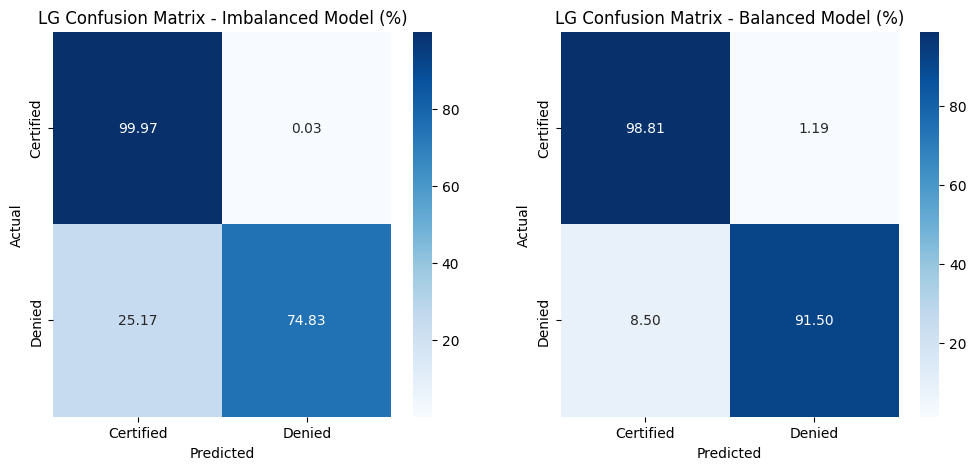

In [152]:
#compute confusion matrix and plot
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', ax=ax, xticklabels=['Certified', 'Denied'], yticklabels=['Certified', 'Denied'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, lg_imbalanced_y_pred, 'LG Confusion Matrix - Imbalanced Model (%)', axes[0])
plot_confusion_matrix(y_test, lg_y_pred, 'LG Confusion Matrix - Balanced Model (%)', axes[1])
plt.show()

### Neural Network

In [153]:
#set up nn
def create_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_nn()

/Users/christie/GitHub/Capstone/.conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [154]:
#Train with imbalanced dataset
nn_imbalanced = create_nn()
nn_imbalanced.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the imbalanced model
nn_y_pred_imbalanced = (nn_imbalanced.predict(X_test) > 0.5).astype(int)

print("Imbalanced Neural Network:")
print("Accuracy of imbalanced NN:", accuracy_score(y_test, nn_y_pred_imbalanced))
print(classification_report(y_test, nn_y_pred_imbalanced))

Epoch 1/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 59s 804us/step - accuracy: 0.9893 - loss: 0.0479 - val_accuracy: 0.9930 - val_loss: 527.7796
Epoch 2/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 57s 787us/step - accuracy: 0.9934 - loss: 0.0391 - val_accuracy: 0.9931 - val_loss: 454.3270
Epoch 3/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 56s 770us/step - accuracy: 0.9935 - loss: 0.0385 - val_accuracy: 0.9930 - val_loss: 8955.0283
Epoch 4/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 54s 746us/step - accuracy: 0.9934 - loss: 0.0388 - val_accuracy: 0.9931 - val_loss: 5620.1821
Epoch 5/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 55s 752us/step - accuracy: 0.9933 - loss: 0.0387 - val_accuracy: 0.9930 - val_loss: 3894.6426
Epoch 6/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 54s 745us/step - accuracy: 0.9935 - loss: 0.0383 - val_accuracy: 0.9933 - val_loss: 23023.8457
Epoch 7/10
72496/72496 ━━━━━━━━━━━━━━━━━━━━ 55s 751us/step - accuracy: 0.9934 - loss: 0.0386 - val_accuracy: 0.9932 - val_loss: 27.9554
Epoch 8/10
72496/72496 ━━━━━━━━━━━━━━

In [155]:
#Setting up model with balanced dataset

#Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#scaling 
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [156]:
#Train balanced dataset
nn_balanced = create_nn()
nn_balanced.fit(X_train_smote_scaled, y_train_smote, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the balanced model
nn_y_pred_balanced = (nn_balanced.predict(X_test_scaled) > 0.5).astype(int)
print("Balanced Neural Network with SMOTE:")
print("Accuracy of balanced NN:", accuracy_score(y_test, nn_y_pred_balanced))
print(classification_report(y_test, nn_y_pred_balanced))

/Users/christie/GitHub/Capstone/.conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 90s 623us/step - accuracy: 0.9872 - loss: 0.0399 - val_accuracy: 0.9881 - val_loss: 0.0243
Epoch 2/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 88s 609us/step - accuracy: 0.9914 - loss: 0.0257 - val_accuracy: 0.9883 - val_loss: 0.0230
Epoch 3/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 88s 608us/step - accuracy: 0.9917 - loss: 0.0242 - val_accuracy: 0.9903 - val_loss: 0.0218
Epoch 4/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 88s 609us/step - accuracy: 0.9919 - loss: 0.0235 - val_accuracy: 0.9907 - val_loss: 0.0210
Epoch 5/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 88s 609us/step - accuracy: 0.9921 - loss: 0.0229 - val_accuracy: 0.9900 - val_loss: 0.0200
Epoch 6/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 88s 609us/step - accuracy: 0.9922 - loss: 0.0224 - val_accuracy: 0.9905 - val_loss: 0.0209
Epoch 7/10
144034/144034 ━━━━━━━━━━━━━━━━━━━━ 89s 615us/step - accuracy: 0.9923 - loss: 0.0223 - val_accuracy: 0.9892 - val_loss: 0.0229
Epoch 8/10
144034/144034 ━━━━━━━━━━━━━━━━

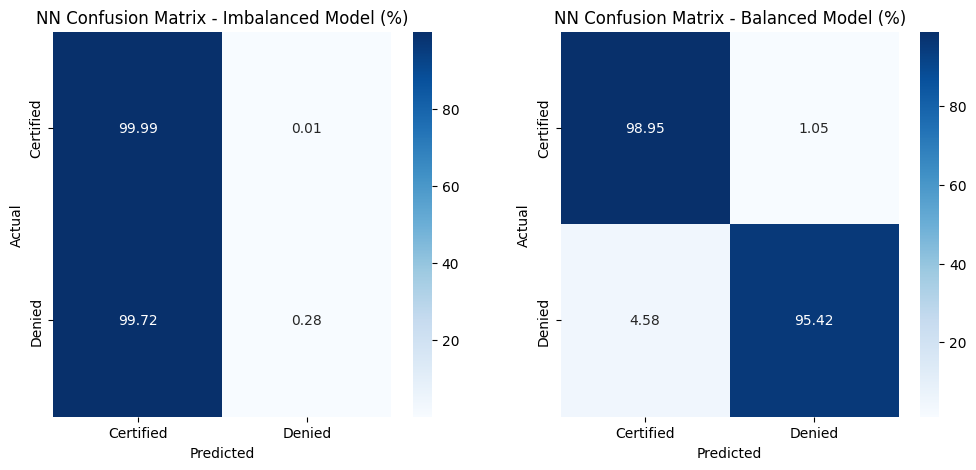

In [157]:
#compute and plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, nn_y_pred_imbalanced, 'NN Confusion Matrix - Imbalanced Model (%)', axes[0])
plot_confusion_matrix(y_test, nn_y_pred_balanced, 'NN Confusion Matrix - Balanced Model (%)', axes[1])
plt.show()


### XGBoost

In [158]:
# Initialize and train XGBoost model
xgb_model_imbalanced = XGBClassifier(eval_metric='logloss')
xgb_model_imbalanced.fit(X_train, y_train)

# Predictions and evaluation
yXGB_pred_imbalanced = xgb_model_imbalanced.predict(X_test)
print("XGBoost_Imbalanced_Accuracy:", accuracy_score(y_test, yXGB_pred_imbalanced))
print(classification_report(y_test, yXGB_pred_imbalanced))

XGBoost_Imbalanced_Accuracy: 0.9988473457268813
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    987767
           1       0.98      0.84      0.90      6460

    accuracy                           1.00    994227
   macro avg       0.99      0.92      0.95    994227
weighted avg       1.00      1.00      1.00    994227



In [159]:
# Apply oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Train XGBoost with balanced data
xgb_model_balanced = XGBClassifier(eval_metric='logloss')
xgb_model_balanced.fit(X_resampled, y_resampled)

# Predictions and evaluation
yXGB_pred_balanced = xgb_model_balanced.predict(X_test)
print("XGBoost_Balanced_Accuracy_:", accuracy_score(y_test, yXGB_pred_balanced))
print(classification_report(y_test, yXGB_pred_balanced))

XGBoost_Balanced_Accuracy_: 0.9928034543419159
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    987767
           1       0.47      0.97      0.64      6460

    accuracy                           0.99    994227
   macro avg       0.74      0.98      0.82    994227
weighted avg       1.00      0.99      0.99    994227



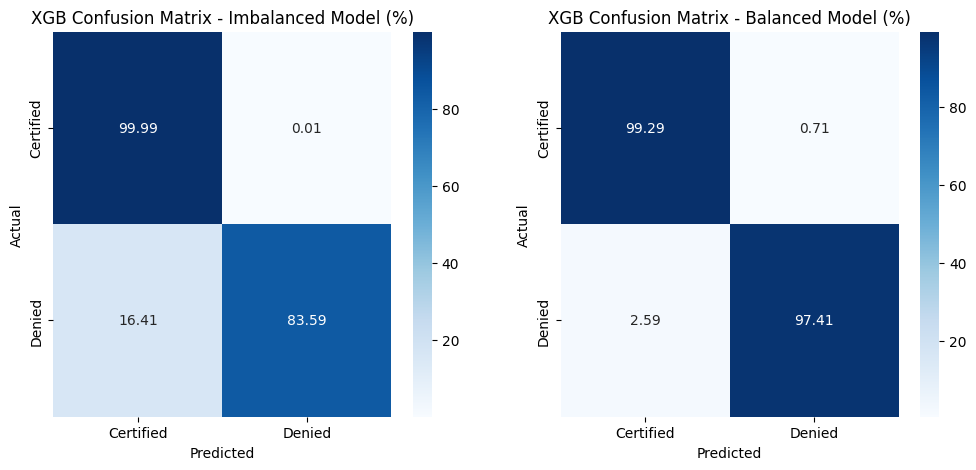

In [165]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, yXGB_pred_imbalanced, 'XGB Confusion Matrix - Imbalanced Model (%)', axes[0])
plot_confusion_matrix(y_test, yXGB_pred_balanced, 'XGB Confusion Matrix - Balanced Model (%)', axes[1])
plt.show()

The comparison between the imbalanced and balanced models reveals that the balanced model is more suitable for the H1B visa certification prediction task. The imbalanced model, trained on the original dataset with a high prevalence of certified cases, exhibited strong bias towards the majority class, correctly classifying 99.99% of certified cases but only 8.02% of denied cases. This model's high false negative rate significantly undermines its reliability for predicting certification outcomes. In contrast, the balanced model, trained with oversampled data, demonstrated a more equitable performance, correctly identifying 82.62% of certified cases and 75.60% of denied cases. Although the balanced model introduced a slight increase in false negatives, its improved ability to correctly classify certified cases makes it the preferred choice. The balanced model's enhanced predictive capability for the minority class is crucial in the context of H1B visa analysis, where accurate identification of certification outcomes is essential for meaningful insights and decision-making.

### Random Forest

In [162]:
# Initialize and train Random Forest model
rf_model_imbalanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_imbalanced.fit(X_train, y_train)

# Predictions and evaluation
yRF_pred_imbalanced = rf_model_imbalanced.predict(X_test)
print("Accuracy_Random Forest:", accuracy_score(y_test, yRF_pred_imbalanced))
print(classification_report(y_test, yRF_pred_imbalanced))

Accuracy_Random Forest: 0.9988895896007652
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    987767
           1       0.99      0.84      0.91      6460

    accuracy                           1.00    994227
   macro avg       1.00      0.92      0.95    994227
weighted avg       1.00      1.00      1.00    994227



In [163]:
# Initialize and train Random Forest model with balanced train dataset
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_balanced.fit(X_resampled, y_resampled)

# Predictions and evaluation
yRF_pred_balanced = rf_model_balanced.predict(X_test)
print("Accuracy_Random Forest:", accuracy_score(y_test, yRF_pred_balanced))
print(classification_report(y_test, yRF_pred_balanced))

Accuracy_Random Forest: 0.9988634386312181
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    987767
           1       0.98      0.85      0.91      6460

    accuracy                           1.00    994227
   macro avg       0.99      0.92      0.95    994227
weighted avg       1.00      1.00      1.00    994227



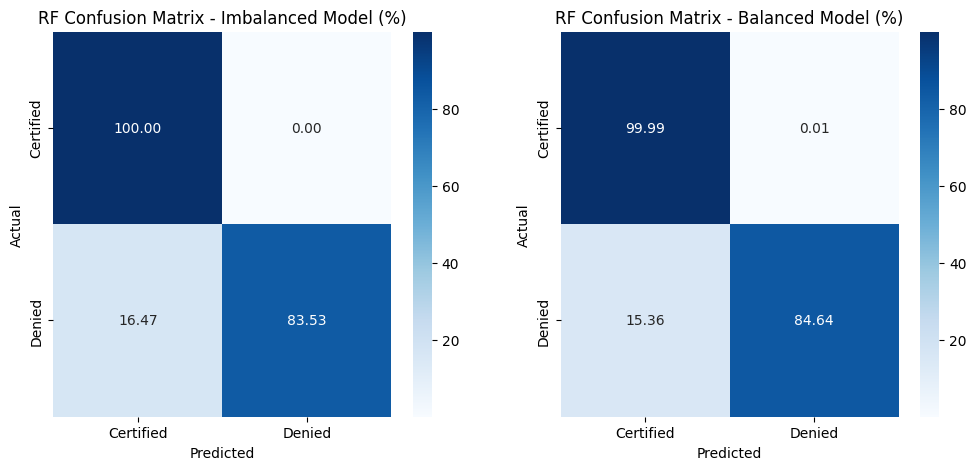

In [164]:
# Visualization 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, yRF_pred_imbalanced, 'RF Confusion Matrix - Imbalanced Model (%)', axes[0])
plot_confusion_matrix(y_test, yRF_pred_balanced, 'RF Confusion Matrix - Balanced Model (%)', axes[1])
plt.show()